In [2]:
import os
import cv2
import numpy as np
import shutil
import random

def random_augment(img):
    """
    Apply a random color or brightness augmentation:
    1. Convert to grayscale
    2. Add a reddish tint
    3. Brighten
    4. Darken
    """
    transform = random.choice(["gray", "red", "bright_up", "bright_down"])

    if transform == "gray":
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Convert back to 3-channel so shape remains (H, W, 3)
        img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    elif transform == "red":
        # Increase red channel for a reddish tint
        b, g, r = cv2.split(img)
        r = cv2.add(r, 50)  # shift red channel
        r = np.clip(r, 0, 255).astype(np.uint8)
        img = cv2.merge([b, g, r])

    elif transform == "bright_up":
        # Increase brightness and contrast slightly
        img = cv2.convertScaleAbs(img, alpha=1.2, beta=20)

    elif transform == "bright_down":
        # Decrease brightness and contrast slightly
        img = cv2.convertScaleAbs(img, alpha=0.8, beta=-20)

    return img

def create_augmented_dataset(input_dir, output_dir):
    """
    Copy the dataset structure from input_dir to output_dir and apply
    color/brightness augmentations to each image. Labels are copied unchanged.

    Expected structure in input_dir:
    input_dir/
    ├── train
    │   ├── images
    │   └── labels
    ├── valid
    │   ├── images
    │   └── labels
    └── test
        ├── images
        └── labels

    Resulting structure in output_dir:
    output_dir/
    ├── train
    │   ├── images
    │   └── labels
    ├── valid
    │   ├── images
    │   └── labels
    └── test
        ├── images
        └── labels
    """
    subsets = ["train", "valid", "test"]

    for subset in subsets:
        images_in = os.path.join(input_dir, subset, "images")
        labels_in = os.path.join(input_dir, subset, "labels")

        images_out = os.path.join(output_dir, subset, "images")
        labels_out = os.path.join(output_dir, subset, "labels")

        os.makedirs(images_out, exist_ok=True)
        os.makedirs(labels_out, exist_ok=True)

        # Go through each image in the subset
        if not os.path.isdir(images_in):
            print(f"Warning: no images folder found for '{subset}' at {images_in}")
            continue

        for img_file in os.listdir(images_in):
            # Only process image files
            if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            # Read the original image
            img_path = os.path.join(images_in, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: failed to load image {img_path}")
                continue

            # Apply a random augmentation
            aug_img = random_augment(img)

            # Save augmented image
            out_img_path = os.path.join(images_out, img_file)
            cv2.imwrite(out_img_path, aug_img)

            # Copy the corresponding label file (if it exists)
            label_file = os.path.splitext(img_file)[0] + ".txt"
            label_src = os.path.join(labels_in, label_file)
            label_dst = os.path.join(labels_out, label_file)
            if os.path.exists(label_src):
                shutil.copy(label_src, label_dst)

if __name__ == "__main__":
    # Example usage:
    # Suppose your original dataset is in 'annotations' with subfolders train/valid/test
    input_dataset = "dataset"

    # The new dataset with augmentations will be stored in 'new_dataset'
    output_dataset = "new_dataset"

    create_augmented_dataset(input_dataset, output_dataset)
    print("Augmented dataset created successfully!")


Augmented dataset created successfully!


# YOLO v8

In [3]:
from ultralytics import YOLO

In [10]:
model = YOLO("yolo_models/yolov8n.pt")  # or "yolo_models/yolov8n.pt"
model.train(
    data="dataset.yaml",  # path to the YAML file above
    epochs=55,
    imgsz=416,
    batch=16,
    half=False,  # disable FP16 if desired

    # Built-in augmentations:
    hsv_h=0.015,        # Adjust hue
    hsv_s=0.7,          # Adjust saturation
    hsv_v=0.4,          # Adjust value/brightness
    fliplr=0.5,         # 50% chance to flip images horizontally
    flipud=0.0,         # 0% chance to flip vertically
    scale=0.9,          # Random scale
    translate=0.1,      # Random translation
    mosaic=1.0,         # Use Mosaic augmentation
    mixup=0.1           # Use MixUp augmentation
)

New https://pypi.org/project/ultralytics/8.3.85 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.82  Python-3.12.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo_models/yolov8n.pt, data=dataset.yaml, epochs=55, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Machine Learning\Rat-Tracking-using-YOLO\new_dataset\train\labels.cache... 282 images, 1 backgrounds, 0 corrupt: 100%|██████████| 282/282 [00:00<?, ?it/s]
val: Scanning C:\Machine Learning\Rat-Tracking-using-YOLO\new_dataset\valid\labels.cache... 73 images, 1 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]


No module named 'seaborn'
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to c:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5
Starting training for 55 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/55     0.992G      1.456      2.795      1.349         30        416: 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


                   all         73         72          1      0.512      0.917      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/55     0.939G       1.49      1.751      1.362         24        416: 100%|██████████| 18/18 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         73         72     0.0108          1      0.882      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/55     0.938G       1.49      1.497      1.344         27        416: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         73         72      0.959      0.326      0.918      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/55     0.938G      1.465      1.364      1.383         22        416: 100%|██████████| 18/18 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         73         72          1      0.106      0.389       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/55     0.938G      1.474      1.308      1.321         29        416: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         73         72      0.567      0.455      0.438      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/55     0.936G        1.5       1.33      1.361         23        416: 100%|██████████| 18/18 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         73         72      0.664      0.486      0.613      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/55     0.936G      1.569      1.374      1.399         21        416: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         73         72       0.68      0.592      0.704      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/55     0.936G      1.493      1.271      1.418         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         73         72       0.78      0.875      0.898       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/55     0.938G       1.51      1.294      1.387         33        416: 100%|██████████| 18/18 [00:03<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         73         72      0.704      0.639      0.754      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/55     0.936G       1.47       1.21      1.393         23        416: 100%|██████████| 18/18 [00:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


                   all         73         72        0.8      0.819      0.841      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/55     0.934G      1.467      1.179      1.364         27        416: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         73         72      0.883      0.945      0.966      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/55     0.934G       1.52       1.21      1.442         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         73         72      0.946      0.981      0.989      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/55     0.938G      1.487      1.211      1.419         26        416: 100%|██████████| 18/18 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         73         72      0.943      0.925      0.972      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/55     0.938G      1.408       1.07       1.35         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         73         72      0.969      0.986      0.981      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/55     0.936G      1.421      1.071      1.328         20        416: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         73         72      0.947          1      0.981      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/55     0.938G      1.364      1.045      1.308         22        416: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         73         72      0.972          1       0.99      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/55     0.936G      1.375      1.036      1.314         18        416: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         73         72      0.956          1      0.993      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/55     0.939G      1.392      1.014      1.306         30        416: 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         73         72      0.967      0.986       0.99      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/55     0.936G      1.358      0.962      1.312         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

                   all         73         72      0.947      0.984      0.979      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/55     0.936G      1.289     0.9563       1.27         24        416: 100%|██████████| 18/18 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         73         72      0.944      0.986      0.991      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/55     0.938G      1.331      1.026      1.317         16        416: 100%|██████████| 18/18 [00:03<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         73         72      0.946      0.974       0.99      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/55     0.938G       1.34      0.964      1.294         29        416: 100%|██████████| 18/18 [00:03<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         73         72      0.986      0.998      0.993      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/55     0.936G       1.29     0.9171      1.292         18        416: 100%|██████████| 18/18 [00:03<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         73         72       0.96      0.972      0.986      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/55     0.936G      1.318     0.9545      1.286         20        416: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         73         72       0.96      0.988      0.984      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/55     0.938G      1.314     0.9179      1.275         25        416: 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         73         72      0.946          1       0.99      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/55     0.936G      1.328     0.9427      1.307         16        416: 100%|██████████| 18/18 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         73         72      0.965          1      0.987      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/55     0.932G      1.285     0.9221      1.264         32        416: 100%|██████████| 18/18 [00:03<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         73         72      0.973      0.999      0.991      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/55     0.936G        1.3     0.8815      1.241         26        416: 100%|██████████| 18/18 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         73         72      0.947      0.983      0.988      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/55     0.934G      1.319     0.8741      1.283         23        416: 100%|██████████| 18/18 [00:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         73         72      0.968      0.986      0.993      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/55     0.934G      1.244     0.8613      1.259         20        416: 100%|██████████| 18/18 [00:03<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         73         72       0.97          1      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/55     0.936G      1.221     0.8425      1.226         19        416: 100%|██████████| 18/18 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         73         72      0.985          1      0.991      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/55     0.934G      1.297     0.9006      1.289         20        416: 100%|██████████| 18/18 [00:03<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         73         72      0.984          1      0.994      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/55     0.938G      1.266     0.8342      1.257         25        416: 100%|██████████| 18/18 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         73         72      0.984          1      0.993      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/55     0.936G      1.224     0.8264      1.254         17        416: 100%|██████████| 18/18 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         73         72      0.984          1       0.99       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/55     0.934G      1.207     0.7951      1.228         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         73         72      0.969      0.986      0.984      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/55     0.938G      1.228     0.8001      1.237         34        416: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         73         72      0.963      0.972      0.978      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/55     0.934G      1.273     0.8166      1.249         16        416: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         73         72      0.936      0.986      0.975      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/55     0.938G      1.217     0.8269      1.235         19        416: 100%|██████████| 18/18 [00:03<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         73         72      0.958      0.986      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/55     0.936G      1.221     0.8047      1.215         20        416: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         73         72       0.96          1      0.988      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/55     0.936G      1.227     0.7986      1.249         21        416: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         73         72      0.975      0.972      0.987      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/55     0.936G      1.215     0.7936       1.23         23        416: 100%|██████████| 18/18 [00:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         73         72      0.985      0.972      0.986      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/55     0.936G      1.213     0.7393      1.203         21        416: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         73         72      0.968          1      0.989      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/55     0.936G      1.202     0.7829      1.208         29        416: 100%|██████████| 18/18 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         73         72      0.984      0.972       0.99      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/55     0.934G       1.21     0.7327      1.231         26        416: 100%|██████████| 18/18 [00:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         73         72      0.986      0.984      0.992      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/55     0.936G      1.186     0.7093      1.199         20        416: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         73         72      0.973      0.999       0.99      0.744


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/55     0.932G      1.046     0.6961      1.256         10        416: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         73         72      0.958      0.986      0.987      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/55     0.932G      1.015     0.6551      1.226          9        416: 100%|██████████| 18/18 [00:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all         73         72      0.945      0.986      0.987      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/55     0.932G     0.9803     0.6591      1.196         10        416: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all         73         72      0.972      0.986      0.992       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/55     0.932G     0.9983     0.6381      1.222         10        416: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         73         72      0.972      0.986      0.992      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/55     0.932G     0.9996     0.6151      1.196          9        416: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

                   all         73         72      0.984      0.986      0.992      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/55     0.932G      0.977     0.6067      1.163         10        416: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

                   all         73         72       0.98      0.986      0.991       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/55     0.932G     0.9906     0.6264      1.228         10        416: 100%|██████████| 18/18 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         73         72      0.984      0.986      0.991      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/55     0.932G      0.946     0.6072      1.167          9        416: 100%|██████████| 18/18 [00:02<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         73         72      0.986      0.984      0.992       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/55     0.934G     0.9779     0.6111      1.173          9        416: 100%|██████████| 18/18 [00:03<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         73         72      0.973      0.998      0.992       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/55     0.932G     0.9255      0.611      1.162         10        416: 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         73         72      0.973      0.997      0.991      0.751



55 epochs completed in 0.084 hours.
Optimizer stripped from c:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from c:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5\weights\best.pt, 6.2MB

Validating c:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5\weights\best.pt...
Ultralytics 8.3.82  Python-3.12.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


                   all         73         72      0.973      0.998      0.991      0.759
WARNING  ConfusionMatrix plot failure: No module named 'seaborn'
WARNING  ConfusionMatrix plot failure: No module named 'seaborn'
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to c:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020DDEF382F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

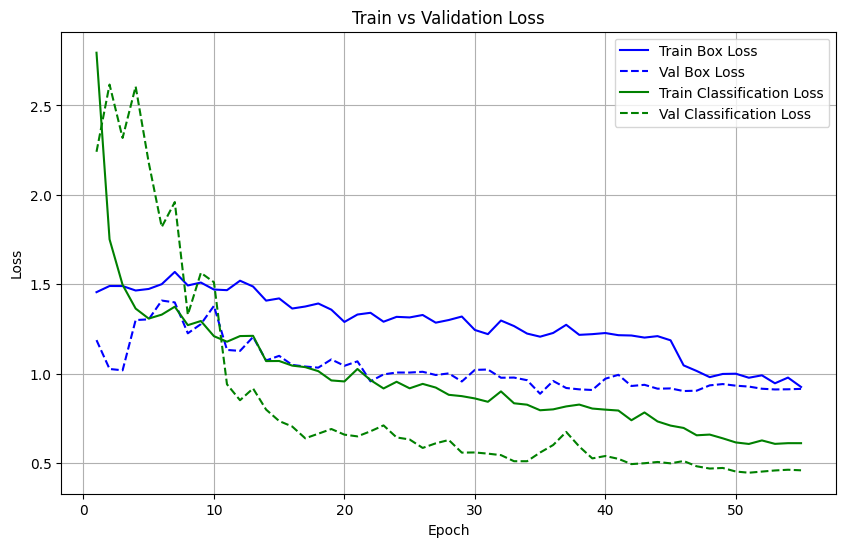

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Path to the results CSV
results_path = "runs/detect/train5/results.csv"

# Read the results CSV
results = pd.read_csv(results_path)

# Plot train vs test losses
plt.figure(figsize=(10, 6))

# Box loss
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss", color="blue")
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss", color="blue", linestyle="dashed")

# Objectness loss
# plt.plot(results["epoch"], results["train/obj_loss"], label="Train Objectness Loss", color="orange")
# plt.plot(results["epoch"], results["val/obj_loss"], label="Val Objectness Loss", color="orange", linestyle="dashed")

# Classification loss
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Classification Loss", color="green")
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Classification Loss", color="green", linestyle="dashed")

# Add labels, legend, and grid
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



0: 416x416 1 rat, 14.7ms
Speed: 2.4ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


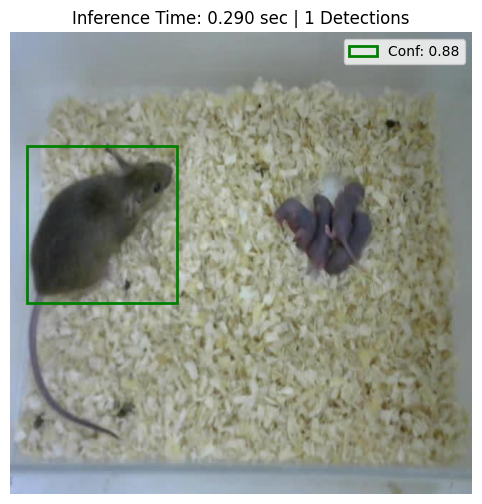

Processed: dataset/test/images\20200507080137_000918_jpg.rf.b7cbbbaae30ce76076c03e8f97a9f55f.jpg | Inference Time: 0.290 sec
✅ Best Detection: [     23.237      158.08      230.68      375.13] | Confidence: 0.88

0: 320x416 1 rat, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 3.1ms postprocess per image at shape (1, 3, 320, 416)


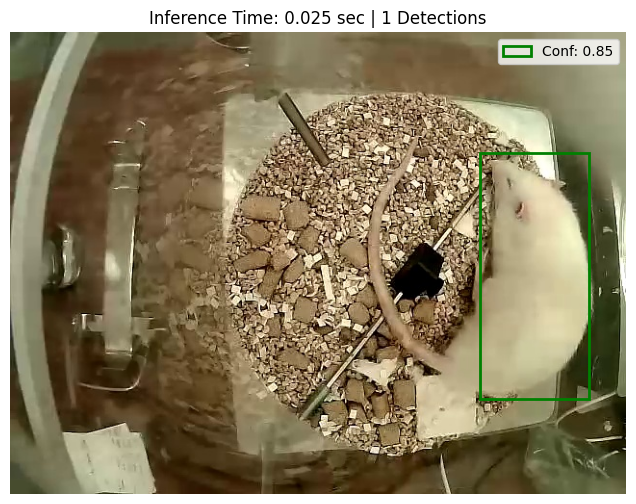

Processed: dataset/test/images\Baseline2_frame_001518.jpg | Inference Time: 0.025 sec
✅ Best Detection: [     487.39      125.38       601.3      380.55] | Confidence: 0.85

0: 320x416 1 rat, 10.0ms
Speed: 1.4ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 416)


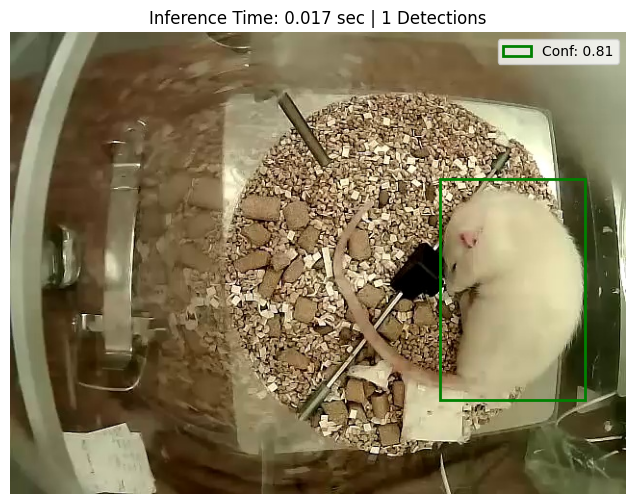

Processed: dataset/test/images\Baseline2_frame_002040.jpg | Inference Time: 0.017 sec
✅ Best Detection: [     446.75      151.98      596.62      382.29] | Confidence: 0.81

0: 320x416 1 rat, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 416)


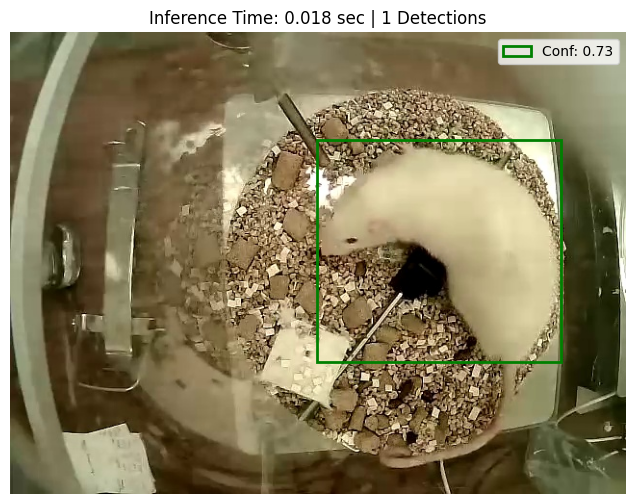

Processed: dataset/test/images\Baseline_frame_001103.jpg | Inference Time: 0.018 sec
✅ Best Detection: [     318.87      111.77      571.47      342.22] | Confidence: 0.73

0: 320x416 1 rat, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 3.5ms postprocess per image at shape (1, 3, 320, 416)


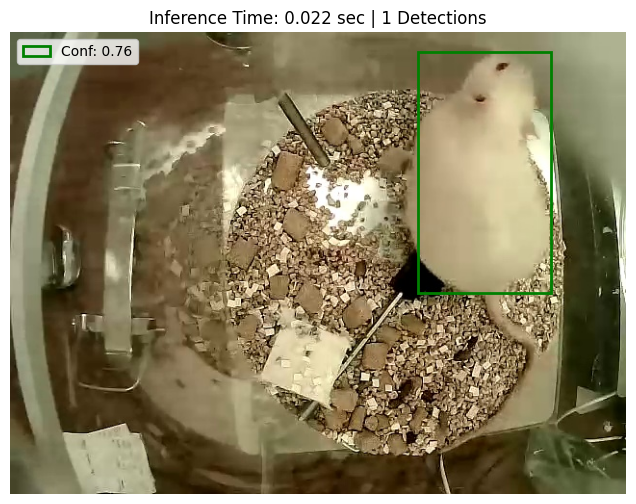

Processed: dataset/test/images\Baseline_frame_001615.jpg | Inference Time: 0.022 sec
✅ Best Detection: [     423.65      20.106      561.29       270.9] | Confidence: 0.76

0: 320x416 1 rat, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 416)


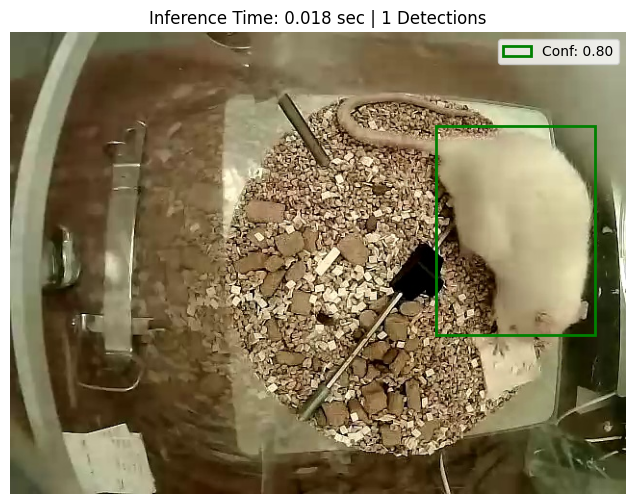

Processed: dataset/test/images\Baseline_frame_036948.jpg | Inference Time: 0.018 sec
✅ Best Detection: [     442.31      97.324      607.69       314.4] | Confidence: 0.80

0: 288x416 1 rat, 13.6ms
Speed: 1.2ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 416)


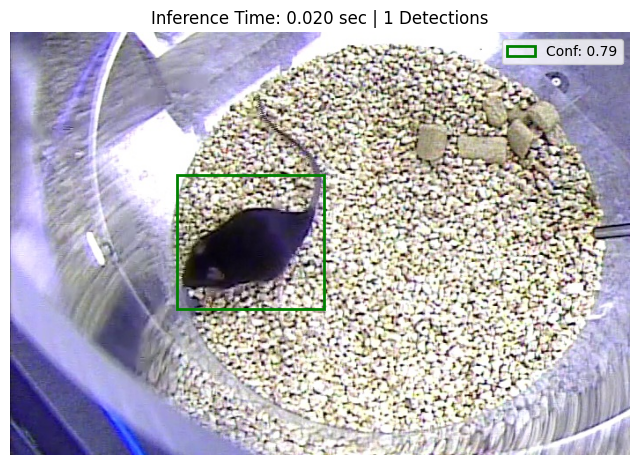

Processed: dataset/test/images\frame_000691.jpg | Inference Time: 0.020 sec
✅ Best Detection: [     189.15      162.01      356.29      313.57] | Confidence: 0.79

0: 288x416 1 rat, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 288, 416)


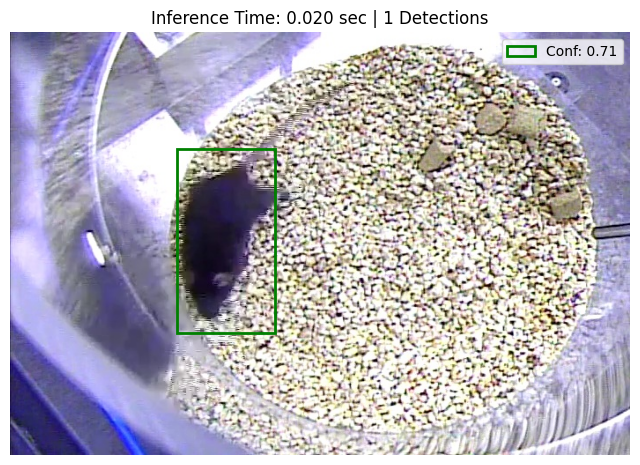

Processed: dataset/test/images\frame_003949.jpg | Inference Time: 0.020 sec
✅ Best Detection: [     189.08       132.3      300.26      340.48] | Confidence: 0.71

0: 288x416 2 rats, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)


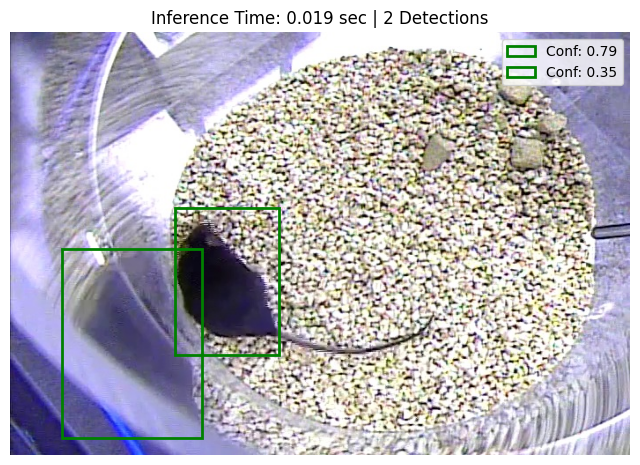

Processed: dataset/test/images\frame_009310.jpg | Inference Time: 0.019 sec
✅ Best Detection: [      186.4      198.83       305.1      366.48] | Confidence: 0.79

0: 288x416 1 rat, 102.7ms
Speed: 1.2ms preprocess, 102.7ms inference, 11.8ms postprocess per image at shape (1, 3, 288, 416)


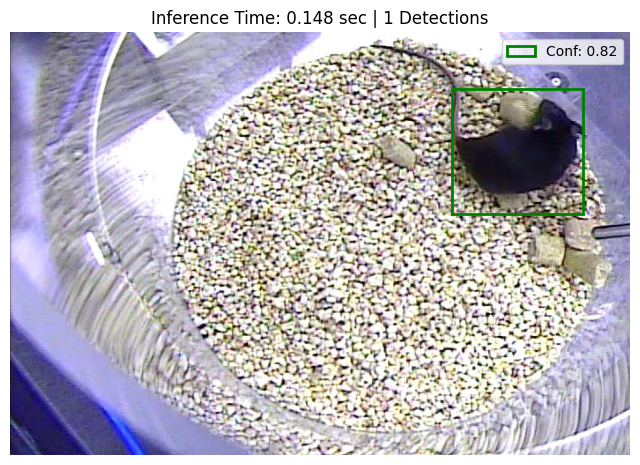

Processed: dataset/test/images\frame_010790.jpg | Inference Time: 0.148 sec
✅ Best Detection: [     501.12      64.085       650.1      205.88] | Confidence: 0.82

0: 288x416 1 rat, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 416)


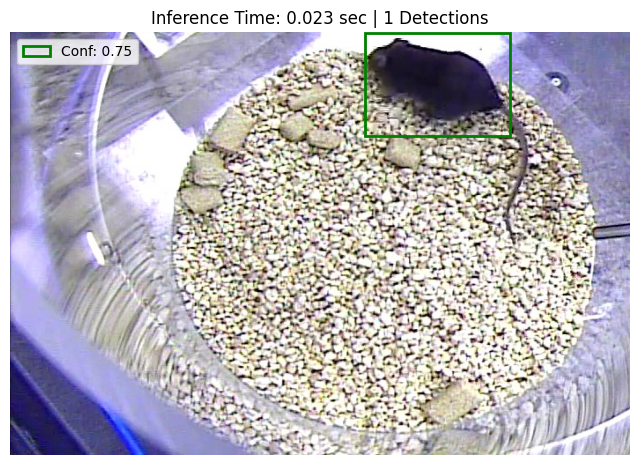

Processed: dataset/test/images\frame_014705.jpg | Inference Time: 0.023 sec
✅ Best Detection: [     402.74           0      566.88      117.23] | Confidence: 0.75


In [12]:
import cv2
import time
import matplotlib.pyplot as plt
from glob import glob
from ultralytics import YOLO
%matplotlib inline

# Load trained YOLOv8 model
model = YOLO("runs/detect/train5/weights/best.pt")  # Adjust model path if needed

# Define test image directory
test_images_dir = "dataset/test/images/"

# Get list of test images
image_paths = glob(test_images_dir + "*.jpg")  # Adjust extension if needed

# Run inference on multiple images and record inference time
for image_path in image_paths[25:]:  # Adjust the number of images to display
    # Load and preprocess image
    # image_path = '/content/Screenshot 2025-02-06 170103.png'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Run inference and measure time
    start_time = time.time()
    results = model(image)
    end_time = time.time()
    inference_time = end_time - start_time

    # Access detection results and filter by confidence
    detection_result = results[0]
    boxes = detection_result.boxes  # Get bounding boxes

    # Filter boxes with confidence > 0.7
    filtered_boxes = [box for box in boxes if box.conf.item() > 0.01]

    # Select the best bounding box (highest confidence)
    best_box = max(filtered_boxes, key=lambda b: b.conf.item(), default=None)

    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)

    if filtered_boxes:
        for box in filtered_boxes:
            bbox = box.xyxy[0].cpu().numpy()  # Bounding box coordinates (x_min, y_min, x_max, y_max)
            conf = box.conf.item()  # Confidence score

            # Plot each bounding box
            plt.gca().add_patch(
                plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                              edgecolor="green", fill=False, linewidth=2, label=f"Conf: {conf:.2f}")
            )

        plt.title(f"Inference Time: {inference_time:.3f} sec | {len(filtered_boxes)} Detections")
        plt.legend()
    else:
        plt.title(f"Inference Time: {inference_time:.3f} sec | No Detections > 0.7")

    plt.axis("off")  # Hide axes
    plt.show()

    print(f"Processed: {image_path} | Inference Time: {inference_time:.3f} sec")

    if best_box:  # Check if best_box is found
        bbox = best_box.xyxy[0].cpu().numpy()
        conf = best_box.conf.item()
        print(f"✅ Best Detection: {bbox} | Confidence: {conf:.2f}")
    else:
        print(f"❌ No detections with confidence > 0.7 for {image_path}")


In [13]:
model.export(format="onnx", opset=12, simplify=True, dynamic=False, imgsz=416)

Ultralytics 8.3.82  Python-3.12.9 torch-2.6.0+cu118 CPU (Intel Core(TM) i5-4690 3.50GHz)

PyTorch: starting from 'runs\detect\train5\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (5.9 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  1.4s, saved as 'runs\detect\train5\weights\best.onnx' (11.6 MB)

Export complete (1.6s)
Results saved to C:\Machine Learning\Rat-Tracking-using-YOLO\runs\detect\train5\weights
Predict:         yolo predict task=detect model=runs\detect\train5\weights\best.onnx imgsz=416  
Validate:        yolo val task=detect model=runs\detect\train5\weights\best.onnx imgsz=416 data=dataset.yaml  
Visualize:       https://netron.app


'runs\\detect\\train5\\weights\\best.onnx'

In [ ]:
# import time
# import cv2
# import numpy as np
# import onnxruntime
# import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow  # For Colab image display

# # Utility functions
# def xywh2xyxy(x):
#     """Convert [x_center, y_center, width, height] to [x1, y1, x2, y2]"""
#     y = np.copy(x)
#     y[:, 0] = x[:, 0] - x[:, 2] / 2  # x1
#     y[:, 1] = x[:, 1] - x[:, 3] / 2  # y1
#     y[:, 2] = x[:, 0] + x[:, 2] / 2  # x2
#     y[:, 3] = x[:, 1] + x[:, 3] / 2  # y2
#     return y

# def draw_detections(image, boxes, scores, class_ids, conf_threshold=0.3):
#     """Draw bounding boxes on image"""
#     for i in range(len(boxes)):
#         x1, y1, x2, y2 = map(int, boxes[i])
#         conf = scores[i]

#         # Draw bounding box
#         color = (0, 255, 0)  # Green
#         cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

#         # Label
#         label = f"Class {int(class_ids[i])}: {conf:.2f}"
#         cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

#     return image

# class YOLOv8_ONNX:
#     def __init__(self, model_path, conf_thres=0.3, iou_thres=0.5):
#         self.conf_threshold = conf_thres
#         self.iou_threshold = iou_thres

#         # Load ONNX model
#         self.session = onnxruntime.InferenceSession(model_path, providers=onnxruntime.get_available_providers())

#         # Get input & output details
#         self.get_input_details()
#         self.get_output_details()

#     def get_input_details(self):
#         model_inputs = self.session.get_inputs()
#         self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]
#         self.input_shape = model_inputs[0].shape
#         self.input_height = self.input_shape[2]
#         self.input_width = self.input_shape[3]

#     def get_output_details(self):
#         model_outputs = self.session.get_outputs()
#         self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]

#     def preprocess_image(self, image):
#         """Prepare image for YOLOv8 model"""
#         self.img_height, self.img_width = image.shape[:2]

#         img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         img_resized = cv2.resize(img_rgb, (self.input_width, self.input_height))

#         img_resized = img_resized / 255.0  # Normalize
#         img_transposed = img_resized.transpose(2, 0, 1)  # HWC -> CHW
#         img_input = np.expand_dims(img_transposed, axis=0).astype(np.float32)

#         return img_input

#     def infer(self, image):
#         """Run inference on an image"""
#         input_tensor = self.preprocess_image(image)
#         outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})
#         return self.process_output(outputs)

#     def process_output(self, output):
#         """Process YOLOv8 output"""
#         predictions = np.squeeze(output[0]).T

#         # Get confidence scores and filter by threshold
#         scores = np.max(predictions[:, 4:], axis=1)
#         predictions = predictions[scores > self.conf_threshold, :]
#         scores = scores[scores > self.conf_threshold]

#         if len(scores) == 0:
#             return [], [], []

#         class_ids = np.argmax(predictions[:, 4:], axis=1)
#         boxes = self.rescale_boxes(predictions[:, :4])

#         return boxes, scores, class_ids

#     def rescale_boxes(self, boxes):
#         """Convert YOLO format (center x, center y, width, height) to image coordinates"""
#         input_shape = np.array([self.input_width, self.input_height, self.input_width, self.input_height])
#         boxes = np.divide(boxes, input_shape, dtype=np.float32)
#         boxes *= np.array([self.img_width, self.img_height, self.img_width, self.img_height])
#         return xywh2xyxy(boxes)

# # Load YOLOv8 ONNX model
# model_path = "/content/runs/detect/train/weights/best.onnx"  # Update with your actual path
# yolo_detector = YOLOv8_ONNX(model_path, conf_thres=0.3, iou_thres=0.5)

# # Load Test Image
# image_path = "/content/new_dataset/test/images/frame_003949.jpg"  # Update with your actual path
# img = cv2.imread(image_path)
# if img is None:
#     raise ValueError(f"❌ Error: Unable to load image from {image_path}")

# # Detect objects
# boxes, scores, class_ids = yolo_detector.infer(img)

# # Draw detections
# img_with_detections = draw_detections(img, boxes, scores, class_ids)

# # Show the image with bounding boxes
# cv2_imshow(img_with_detections)


# ✅ Run on CPU & Single Core

In [ ]:
# import cv2
# import time
# import torch
# from ultralytics import YOLO
# import os

# # Force YOLO to run on CPU only and limit to 1 core
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
# torch.set_num_threads(1)  # Limit PyTorch to 1 CPU core

# # Load trained YOLOv8 model (force CPU usage)
# model = YOLO("/content/drive/MyDrive/Colab Notebooks/runs/detect/train/weights/best.pt")  # Adjust model path if needed

# # Path to input video
# input_video_path = "/content/drive/MyDrive/Colab Notebooks/TestFile_video.mp4"
# output_video_path = "/content/drive/MyDrive/Colab Notebooks/output_video.mp4"

# # Open the video file
# cap = cv2.VideoCapture(input_video_path)

# # Get video properties
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = int(cap.get(cv2.CAP_PROP_FPS))

# # Define a VideoWriter to save the output
# fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
# out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# # Track time and limit processing to 1 minute (60 seconds)
# start_time_global = time.time()

# # Process video frame by frame
# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break  # Exit if no frame is returned

#     # Stop processing after 60 seconds
#     elapsed_time = time.time() - start_time_global
#     if elapsed_time > 60:
#         print("Stopping processing: 1-minute limit reached.")
#         break

#     # Convert BGR frame (OpenCV default) to RGB for YOLO
#     rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Run YOLO inference and measure time (on CPU)
#     start_time = time.time()
#     results = model(rgb_frame, device="cpu")  # Ensure YOLO runs on CPU
#     end_time = time.time()
#     inference_time = end_time - start_time

#     # Access detection results and filter boxes with confidence > 0.7
#     detection_result = results[0]
#     boxes = detection_result.boxes  # Get bounding boxes
#     filtered_boxes = [box for box in boxes if box.conf.item() > 0.7]

#     # Draw bounding boxes on the frame
#     for box in filtered_boxes:
#         bbox = box.xyxy[0].cpu().numpy()  # Bounding box coordinates (x_min, y_min, x_max, y_max)
#         conf = box.conf.item()  # Confidence score

#         # Draw the bounding box
#         x_min, y_min, x_max, y_max = map(int, bbox)
#         cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box
#         cv2.putText(frame, f"Conf: {conf:.2f}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

#     # Display inference time on the frame
#     cv2.putText(frame, f"Inference Time: {inference_time:.3f} sec", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

#     # Save the processed frame to the output video
#     out.write(frame)

# # Release resources
# cap.release()
# out.release()
# cv2.destroyAllWindows()

# print(f"Processed video (1-minute limit) saved at {output_video_path}")
